In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
%matplotlib inline
np.set_printoptions(suppress=True, precision=10)
from paramz.transformations import Logexp
import itertools

class SimpleModel(GPy.Model):
    def __init__(self, name, dims, priors=False):
        super(SimpleModel, self).__init__(name)
        self.params = []
        self.peak_loc = range(1,dims+1,1)
        for i,pos in enumerate(self.peak_loc):

            p = GPy.Param('param%d' % i, 1.0)
            self.params.append(p)
            self.link_parameter(p)
            if priors:
                p.set_prior(GPy.priors.Gaussian(2.0, 3.0))
    
    def log_likelihood(self):
        like = 0
        for i,pos in enumerate(self.peak_loc):
            like -= ((self.params[i])-pos)**2
        return like[0]
    
    def parameters_changed(self):
        for i,pos in enumerate(self.peak_loc):
            self.params[i].gradient = -2*((self.params[i])-pos)
            
def find_likes(m,stepsize=0.4,rangemin=-7,rangemax=7):
    """
    Numerical grid integral over model parameters
    This function returns the sum of the objective
    """
    m.optimize()
    params = m.optimizer_array[None,:].copy()
    param_ranges = []
    for param in params[0]:
        param_ranges.append(np.arange(rangemin,rangemax,stepsize))        
    combs = itertools.product(*param_ranges)
    lsum = 0
    for el in combs:
        lsum+=np.exp(-m._objective(el))
    return lsum*(stepsize**len(params[0]))

def monte_carlo_int(m,steps=1500):
    """
    My quick and dirty monte carlo integration.
    Returns a mean and the bounds of the 95%
    confidence interval.
    """
    m.optimize()
    opt = m.optimizer_array[None,:].copy()
    nparams = len(m.optimizer_array)
    searchwidth = 8
    V = searchwidth**nparams
    # Take uniform random numbers searchwidth/2 either side
    randnos = (np.random.rand(steps,nparams)-0.5)*searchwidth
    #randnos[:,2]=0
    # Spread the random points around the found maxima
    test_params = randnos+opt.repeat(steps,0)[:]
    tot = []
    for i in range(steps):
        # Evaluate the likelihood at all the test parameter points
        tot.append(np.exp(-m._objective(test_params[i,:])))
    
    mean = V*np.mean(tot)
    ste = V*np.std(tot)/np.sqrt(len(tot))
    return mean,mean-ste*1.96,mean+ste*1.96,nparams

warning in stationary: failed to import cython module: falling back to numpy


In [7]:
m2._log_marginal_likelihood

AttributeError: 'SimpleModel' object has no attribute '_log_marginal_likelihood'

In [4]:
for priors in [False, True]:
    print("====Simple model",end='')
    if priors:
        print("(with priors)====")
    else:
        print("(no priors)====")
    for dims in range(1,5):        
        print("==%d dimensions==" % dims)
        stepsize=0.4*dims #make step size bigger as dims goes up so this isn't too slow
        m2 = SimpleModel('simple',dims,priors)
        numsum = find_likes(m2,stepsize)
        m2.optimize()
        hes = m2.numerical_parameter_hessian()
        m2.optimize()
        #hessum = np.exp(m2.log_likelihood())*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hes))
        hessum = np.exp(-m2._objective(m2.param_array))*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hes))
        ccdpos,ccddensity,scalings,z,ccd_weights = m2.CCD()
        tot = 0
        print("CCD weights:")
        print(ccd_weights)
        for pos,dens,weights in zip(ccdpos,ccddensity,ccd_weights):
            m2.param_array[:] = pos
            tot += dens * np.exp(-m2.log_likelihood())
            #print(den, m2.param_array[:], -m2.log_likelihood(), len(pos))
            #tot += weights*dens
            #tot+= dens*np.exp(-m2._objective(pos))
        print("Weighted CCD approximation")
        print(tot)
        print("Numerical approximation")
        print(numsum)
        print("laplace approximation")
        print(hessum)
        #print("Monte carlo")
        #print(monte_carlo_int(m2))
        #assert np.isclose(hessum,numsum,rtol=0.3), "Simple Model: Laplace approximation using numerical_parameter_hessian()=%0.4f not equal to numerical grid sum=%0.4f" % (hessum,numsum)

====Simple model(no priors)====
==1 dimensions==
CCD weights:
[[ 0.4350346592]
 [ 2.9067495379]
 [ 2.9067495379]
 [ 2.9067495379]
 [ 2.9067495379]]
Weighted CCD approximation
0.607839677443
Numerical approximation
1.77245385091
laplace approximation
1.77245385091
==2 dimensions==
CCD weights:
[[ 1.0904701773]
 [ 2.2812820766]
 [ 2.2812820766]
 [ 2.2812820766]
 [ 2.2812820766]
 [ 2.2812820766]
 [ 2.2812820766]
 [ 2.2812820766]
 [ 2.2812820766]]
Weighted CCD approximation
0.407136033309
Numerical approximation
3.14159391487
laplace approximation
3.14159265359
==3 dimensions==
CCD weights:
[[ 2.733403379 ]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]
 [ 2.2494784533]]
Weighted CCD approximation
0.299445948444
Numerical approximation
5.54485305233
laplace approximation
5.56832799683
==4 dimensions==
CCD weights:
[[ 6

In [8]:
m2._objective(m2.param_array)

10.805992761175339

In [10]:
m2.log_prior()

-8.1779735586560207

In [9]:
m2.log_likelihood()

-2.6280192025193192

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
num_test_points = 50
test_ps = np.linspace(-4,4,num_test_points)
lls = np.zeros(num_test_points)
for i, t in enumerate(test_ps):
    #m2.param_array[:] = t
    lls[i] = np.exp(-m2._objective(t))

In [5]:
ccddensity


array([ 0.173553719 ,  0.1033057851,  0.1033057851,  0.1033057851,
        0.1033057851,  0.1033057851,  0.1033057851,  0.1033057851,
        0.1033057851])

Num free parameters: 2 used_walsh_inds: [1 2] ccd_points: [[ 0.  0.]
 [ 1.  1.]
 [-1.  1.]
 [ 1. -1.]
 [-1. -1.]]
ccd_points after adding non-corners: [[ 0.            0.          ]
 [ 1.            1.          ]
 [-1.            1.          ]
 [ 1.           -1.          ]
 [-1.           -1.          ]
 [ 1.4142135624  0.          ]
 [-1.4142135624  0.          ]
 [ 0.            1.4142135624]
 [ 0.           -1.4142135624]]
New j: 0
0
[[ 1.  0.]]
New j: 1
0
[[-1.  0.]]
New j: 2
1
[[ 0.  1.]]
New j: 3
1
[[ 0. -1.]]
[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]
centre weight: 1.0904701772791023
weights
1.99612181699
not weights
[ 1.  2.]
[ 1.7778174593  2.7778174593]
[ 0.2221825407  2.7778174593]
[ 1.7778174593  1.2221825407]
[ 0.2221825407  1.2221825407]
[ 2.1  2. ]
[-0.1  2. ]
[ 1.   3.1]
[ 1.   0.9]


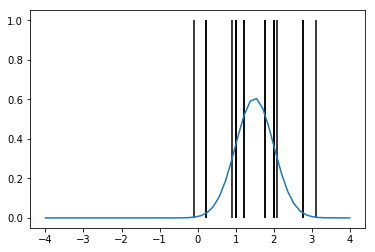

In [6]:
m2.optimize()
ccdpos,ccddensity,scalings,z = m2.CCD()
tot = 0

for pos,den in zip(ccdpos,ccddensity):
    print(pos)
    m2.param_array[:] = pos
    tot += den * np.exp(-m2.log_likelihood())
    #print(den, m2.param_array[:], -m2.log_likelihood(), len(pos))
    #plt.plot(pos,m2.log_likelihood(),'x')
    
plt.plot(test_ps, lls)
plt.vlines(ccdpos, ymin=0,ymax=1)

In [7]:
scalings

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [8]:
m2.optimizer_array[:]

array([ 1. ,  0.9])

In [9]:
print("====GP model====")
#Test numerical_parameter_hessian gives us the right integral for a more complex GP model
#sample data
X = np.arange(0,40,1)[:,None]
Y = np.sin(X/5)+np.random.randn(X.shape[0],X.shape[1])*0.1
k = GPy.kern.RBF(1)

#create model and optimise
m2 = GPy.models.GPRegression(X,Y,k)
m2.Gaussian_noise.fix(0.5)
m2.optimize()

m2.numerical_parameter_hessian()
dims = 2 #equals the number of unfixed parameters
stepsize=0.3
numsum = find_likes(m2,stepsize,rangemin=0.0001,rangemax=20)
m2.optimize()
hes = m2.numerical_parameter_hessian()
hessum = np.exp(m2.log_likelihood())*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hes))
#assert np.isclose(hessum,numsum,rtol=0.1,atol=0), "GP Model: Laplace approximation using numerical_parameter_hessian()=%0.4f not equal to numerical grid sum=%0.4f" % (hessum,numsum)

m2.optimize()
ccdpos,ccdres,scalings,z = m2.CCD()
tot = 0
for i, res in enumerate(ccdres):
    #tot += res * np.exp(-m2.log_likelihood())
    
    tot+= res*np.exp(-m2._objective(ccdpos[i,:]))
    
    #m2.param_array[:] = ccdpos[i,:]
    #tot += res * np.exp(m2.log_likelihood())
print("Weighted sum")
print(tot)
print("Laplace")
print(hessum)
print("Numerical approx")
print(numsum)
print("Monte Carlo")
print(monte_carlo_int(m2))

====GP model====
Num free parameters: 2 used_walsh_inds: [1 2] ccd_points: [[ 0.  0.]
 [ 1.  1.]
 [-1.  1.]
 [ 1. -1.]
 [-1. -1.]]
ccd_points after adding non-corners: [[ 0.            0.          ]
 [ 1.            1.          ]
 [-1.            1.          ]
 [ 1.           -1.          ]
 [-1.           -1.          ]
 [ 1.4142135624  0.          ]
 [-1.4142135624  0.          ]
 [ 0.            1.4142135624]
 [ 0.           -1.4142135624]]
New j: 0
0
[[ 1.  0.]]
New j: 1
0
[[-1.  0.]]
New j: 2
1
[[ 0.  1.]]
New j: 3
1
[[ 0. -1.]]
[[ 1.            1.          ]
 [ 0.8938506289  0.7606041591]
 [ 1.1772606214  0.7606041591]
 [ 0.8938506289  1.1079997103]
 [ 1.1772606214  1.1079997103]
 [ 0.8938506289  1.          ]
 [ 1.1772606214  1.          ]
 [ 1.            0.7606041591]
 [ 1.            1.1079997103]]
weights
1.99612181699
not weights
Weighted sum
9.41652039484e-15
Laplace
3.18673086192e-13
Numerical approx
4.34596508534e-13
Monte Carlo
(3.2322375597773238e-13, 3.047473134788882

In [10]:
num_free_params = 3
for j in range(num_free_params*2):
    temp = np.zeros((1, num_free_params))
    if j % 2:
        direction = -1
    else:
        direction = 1
    ind = int(np.ceil(j // 2))  # This integer division is required, will not work with python 3
    temp[0, ind] = direction
    print(temp)

[[ 1.  0.  0.]]
[[-1.  0.  0.]]
[[ 0.  1.  0.]]
[[ 0. -1.  0.]]
[[ 0.  0.  1.]]
[[ 0.  0. -1.]]


In [11]:
temp

array([[ 0.,  0., -1.]])